# Project Final Report - Who contributes the most data?

Authors: Hunter, Sophia, Jiho, and Freya

## Introduction (write in Introduction.md first)

#### Background Information

...

#### The Question

...

#### The Data

...

## Methods & Results

#### Loading the Data

First, we must load in the nessary libaries for working with data frames, resizing graphs, and working with predictive models respectivley.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Then, we download the player data and read it into R.

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=18CyKdv1ppgp7RraugrDq66w_T-6dkrdG"

download.file(players_url, "players.csv")

players <- read_csv("players.csv")

glimpse(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…


#### Wrangling the Data

We will need to convert the columns to their proper types, so experience will be a factor, Age is an integer, ect. We also want to remove any rows with NA values, which in this case happens to only be in the Age column.

In [3]:
players <- mutate(players,
    experience = as_factor(experience),
    gender = as_factor(gender),
    Age = as.integer(Age)) |>
    filter(!is.na(Age))


players <- players |> 
    select(Age, experience, 
           subscribe, played_hours)

glimpse(players)

Rows: 194
Columns: 4
$ Age          <int> 9, 17, 17, 21, 21, 17, 19, 21, 17, 22, 23, 17, 25, 22, 17…
$ experience   <fct> Pro, Veteran, Veteran, Amateur, Regular, Amateur, Regular…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…


#### Summary of Dataset

Since we are concerned with experience, gender, subscribe, age, and played_hours for our model, let's make some tables of summary statistics for the counts/measures of center of those variables.

In [4]:
summarize(players, 
    average_played_hours = mean(played_hours),
    median_played_hours = median(played_hours),
    average_age = mean(Age),
    median_age = median(Age))

summarize(group_by(players, experience), count = n())

summarize(group_by(players, subscribe), count = n())


average_played_hours,median_played_hours,average_age,median_age
<dbl>,<dbl>,<dbl>,<dbl>
5.904639,0.1,20.52062,19


experience,count
<fct>,<int>
Pro,13
Veteran,48
Amateur,63
Regular,35
Beginner,35


subscribe,count
<lgl>,<int>
FALSE,52
TRUE,142


[additional summary]

#### Visualizations

[description of methods]

In [5]:
# these visualizations are relevant for exploratory data analysis and related to the planned analysis

# note: all figures should have a figure number and a legend

#### Modeling and Analysis

[description of methods]

[1] 145

→ A | warning: 110 samples were requested but there were 114 rows in the data. 109 will be used.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





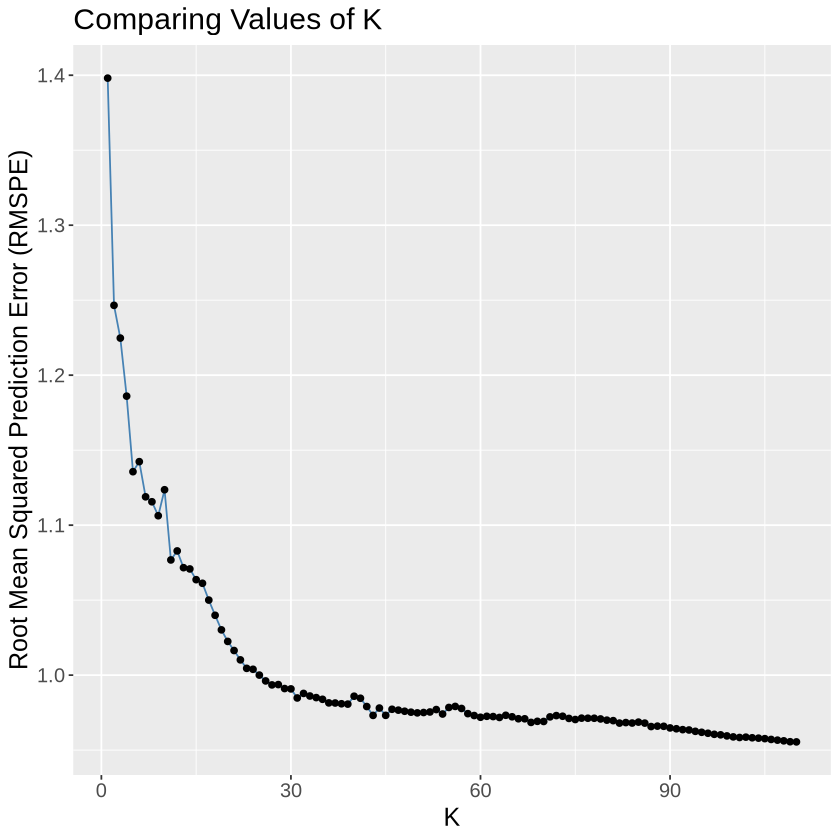

In [7]:
# should include visualizations of model
set.seed(100)

# players <- select(players, -Age)

players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

nrow(players_train)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

knn_recipe <- recipe(played_hours ~ ., data = players_train) |>
  step_scale(all_numeric()) |>
  step_center(all_numeric())

k_vals <- tibble(neighbors = 1:110)

knn_metrics <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    select(neighbors, mean)

metric_plot <- ggplot(knn_metrics, aes(x = neighbors, y = mean)) +
    geom_line(color = "steelblue") +
    geom_point() +
    labs(x = "K", y = "Root Mean Squared Prediction Error (RMSPE)", 
         title = "Comparing Values of K") +
    theme(text = element_text(size = 15))

metric_plot

## Discussion (write in Discussion.md first)

#### Summary

...

#### Is this what you expected?

...

#### What is the impact of the findings?

...

#### Future Questions

...